In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random 
from preprocessing_functions import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score

# Import and undersample the dataset

In [2]:
heart_attack_2020 = pd.read_csv(r'C:\Users\Hp\Documents\Machine_learning_projects\heart_attack_predictions\0_datasets\2020\heart_2020_cleaned.csv')
heart_attack_2020 = undersample_data(heart_attack_2020, 'HeartDisease')
print(heart_attack_2020.value_counts('HeartDisease'))
heart_attack_2020.head()

HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64


,HeartDisease,BMI,Smoking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
111390,No,25.02,No,No,No,Female,50-54,White,No,Yes,Good,6.0,Yes,No,Yes
250162,No,23.30,No,No,No,Female,50-54,Black,No,Yes,Good,7.0,No,No,No
230713,No,25.77,Yes,No,No,Male,45-49,White,No,Yes,Very good,4.0,Yes,No,No
153210,No,25.61,Yes,Yes,No,Female,25-29,White,Yes,No,Fair,6.0,No,No,No
149117,No,31.16,Yes,No,Yes,Female,65-69,Black,No,Yes,Fair,7.0,No,No,No


# Model transforming BMI with log_min_max

## Preprocessing

In [3]:
from preprocessing_functions import *

# numerical features
numerical_features = ['BMI','SleepTime']
# categorical features
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'Sex','AgeCategory', 'Race', 'Diabetic', 
                        'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

heart_attack_2020 = heart_attack_2020[numerical_features + categorical_features + ['HeartDisease']]

# Encoding, scaling and train test split
(Train_df_encoded, Train_labels_encoded), (Valid_df_encoded, 
        Valid_labels_encoded), (Test_df_encoded, Test_labels_encoded) = preprocess_features(heart_attack_2020, one_hot_encoding=False,
                categorical_columns=categorical_features, numerical_tranformer = 'log_min_max',
                numerical_columns=numerical_features, target='HeartDisease')

print(f' train dataset length: {len(Train_df_encoded)}')
print(f' validation dataset length: {len(Valid_df_encoded)}')
print(f' test dataset length: {len(Test_df_encoded)}')

# Creating fast processing dataset
Dataset_train, Dataset_valid, Dataset_test = create_fast_preprocessing_odds(Train_df_encoded, Train_labels_encoded,
        Valid_df_encoded, Valid_labels_encoded, Test_df_encoded, Test_labels_encoded)

Dataset_train

 train dataset length: 46839
 validation dataset length: 4074
 test dataset length: 3833


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Creating checkpoint callback

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='Dense_model_best.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

## Creating the model

In [5]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [6]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

dense_history = model_dense.fit(
                                Dataset_train,
                                epochs=50,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[checkpoint_callback]
                                )

Epoch 1/50


1461/1464 [============================>.] - ETA: 0s - loss: 0.5413 - accuracy: 0.7388
Epoch 1: val_accuracy improved from -inf to 0.76485, saving model to Dense_model_best.h5
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5413 - accuracy: 0.7389 - val_loss: 0.4892 - val_accuracy: 0.7649
Epoch 2/50
1455/1464 [============================>.] - ETA: 0s - loss: 0.5150 - accuracy: 0.7632
Epoch 2: val_accuracy improved from 0.76485 to 0.76583, saving model to Dense_model_best.h5
1464/1464 [==============================] - 3s 2ms/step - loss: 0.5148 - accuracy: 0.7636 - val_loss: 0.4910 - val_accuracy: 0.7658
Epoch 3/50
1457/1464 [============================>.] - ETA: 0s - loss: 0.5082 - accuracy: 0.7644
Epoch 3: val_accuracy improved from 0.76583 to 0.76608, saving model to Dense_model_best.h5
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5080 - accuracy: 0.7647 - val_loss: 0.4913 - val_accuracy: 0.7661
Epoch 4/50
1445/1464 [=======================

### Evaluating the model

0

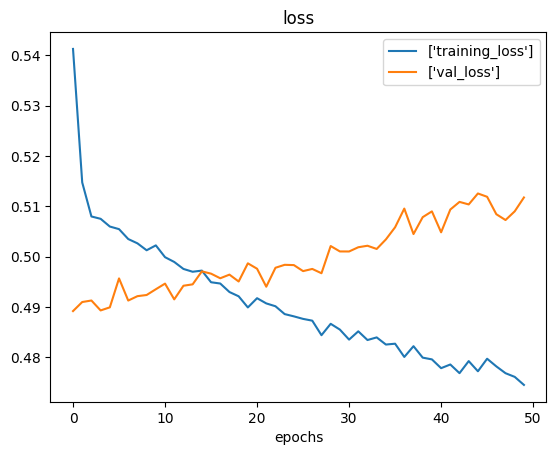

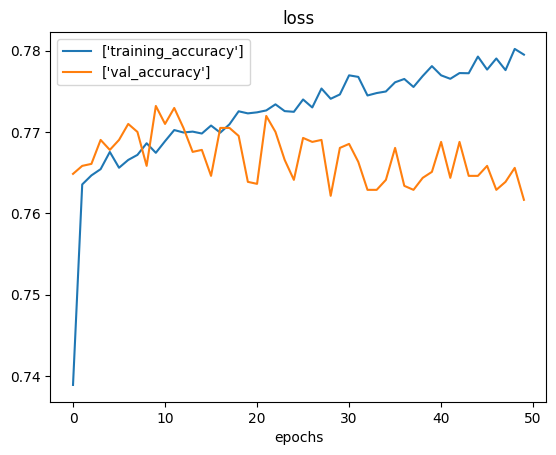

In [7]:
from helper_functions import plot_loss_curve  

plot_loss_curve(dense_history)

## Finding the ideal learning rate

In [21]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

lr_model_dense = tf.keras.Model(inputs, outputs)

lr_model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

#creo il learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5*10**(epoch/20))

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

find_lr_history = lr_model_dense.fit(
                                Dataset_train,
                                epochs=50,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[lr_scheduler]
                                )

Epoch 1/50
1464/1464 [==============================] - 4s 2ms/step - loss: 0.6926 - accuracy: 0.5079 - val_loss: 0.6877 - val_accuracy: 0.5741 - lr: 1.0000e-05
Epoch 2/50
1464/1464 [==============================] - 3s 2ms/step - loss: 0.6842 - accuracy: 0.5380 - val_loss: 0.6721 - val_accuracy: 0.6789 - lr: 1.1220e-05
Epoch 3/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6653 - accuracy: 0.5876 - val_loss: 0.6370 - val_accuracy: 0.7214 - lr: 1.2589e-05
Epoch 4/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6345 - accuracy: 0.6654 - val_loss: 0.5937 - val_accuracy: 0.7275 - lr: 1.4125e-05
Epoch 5/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.6042 - accuracy: 0.7060 - val_loss: 0.5547 - val_accuracy: 0.7371 - lr: 1.5849e-05
Epoch 6/50
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5839 - accuracy: 0.7221 - val_loss: 0.5335 - val_accuracy: 0.7447 - lr: 1.7783e-05
Epoch 7/50
1464/1464 [============

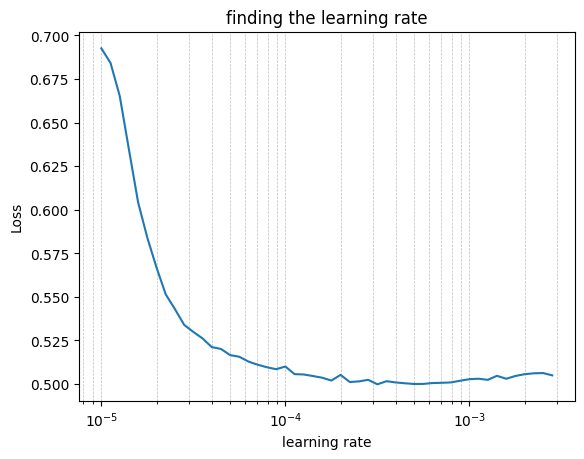

In [22]:
# plotting the loss function in function of the learning rate
lrs = 1e-5 * (10**(tf.range(50)/20))
plt.semilogx(lrs, find_lr_history.history['loss'])
plt.xlabel('learning rate')
plt.ylabel('Loss')
plt.title('finding the learning rate')
plt.grid(which='both', axis='x', linewidth=0.5, linestyle='--', color='gray',
         alpha=0.5, markevery=0.001)


## Model with best lr

In [34]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

In [35]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

dense_history = model_dense.fit(
                                Dataset_train,
                                epochs=60,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[checkpoint_callback]
                                )

Epoch 1/60


1452/1464 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7338
Epoch 1: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5479 - accuracy: 0.7342 - val_loss: 0.4929 - val_accuracy: 0.7617
Epoch 2/60
1451/1464 [============================>.] - ETA: 0s - loss: 0.5158 - accuracy: 0.7627
Epoch 2: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5156 - accuracy: 0.7630 - val_loss: 0.4960 - val_accuracy: 0.7661
Epoch 3/60
1447/1464 [============================>.] - ETA: 0s - loss: 0.5093 - accuracy: 0.7644
Epoch 3: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5090 - accuracy: 0.7647 - val_loss: 0.4922 - val_accuracy: 0.7685
Epoch 4/60
1441/1464 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.7654
Epoch 4: val_accuracy did not improve from 0.77540
1464/1464 [=====

Th best learning rate doesn't have the best val_accuracy performances.

# Model transforming BMI with min_max

## Preprocessing

In [16]:
from preprocessing_functions import *

# numerical features
numerical_features = ['BMI','SleepTime']
# categorical features
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'Sex','AgeCategory', 'Race', 'Diabetic', 
                        'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

heart_attack_2020 = heart_attack_2020[numerical_features + categorical_features + ['HeartDisease']]

# Encoding, scaling and train test split
(Train_df_encoded, Train_labels_encoded), (Valid_df_encoded, 
        Valid_labels_encoded), (Test_df_encoded, Test_labels_encoded) = preprocess_features(heart_attack_2020, one_hot_encoding=False,
                categorical_columns=categorical_features, numerical_tranformer = 'min_max',
                numerical_columns=numerical_features, target='HeartDisease')

print(f' train dataset length: {len(Train_df_encoded)}')
print(f' validation dataset length: {len(Valid_df_encoded)}')
print(f' test dataset length: {len(Test_df_encoded)}')

# Creating fast processing dataset
Dataset_train, Dataset_valid, Dataset_test = create_fast_preprocessing_odds(Train_df_encoded, Train_labels_encoded,
        Valid_df_encoded, Valid_labels_encoded, Test_df_encoded, Test_labels_encoded)

Dataset_train

 train dataset length: 46839
 validation dataset length: 4074
 test dataset length: 3833


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Creating the model

In [17]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(96, activation = 'relu')(inputs)
x = layers.Dense(96)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(64)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [18]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

dense_history = model_dense.fit(
                                Dataset_train,
                                epochs=60,
                                validation_data=Dataset_valid,
                                validation_steps=len(Dataset_valid),
                                callbacks=[checkpoint_callback]
                                )

Epoch 1/60
1452/1464 [============================>.] - ETA: 0s - loss: 0.5362 - accuracy: 0.7442
Epoch 1: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 4s 2ms/step - loss: 0.5357 - accuracy: 0.7446 - val_loss: 0.4893 - val_accuracy: 0.7658
Epoch 2/60
1431/1464 [============================>.] - ETA: 0s - loss: 0.5138 - accuracy: 0.7632
Epoch 2: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5139 - accuracy: 0.7633 - val_loss: 0.4931 - val_accuracy: 0.7683
Epoch 3/60
1450/1464 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.7624
Epoch 3: val_accuracy did not improve from 0.77540
1464/1464 [==============================] - 2s 2ms/step - loss: 0.5097 - accuracy: 0.7627 - val_loss: 0.4913 - val_accuracy: 0.7703
Epoch 4/60
1460/1464 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.7651
Epoch 4: val_accuracy did not improve from 0.77540
1464/

# FInding the best Model

## Preprocessing

In [3]:
from preprocessing_functions import *

# numerical features
numerical_features = ['BMI','SleepTime']
# categorical features
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'Sex','AgeCategory', 'Race', 'Diabetic', 
                        'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

heart_attack_2020 = heart_attack_2020[numerical_features + categorical_features + ['HeartDisease']]

# Encoding, scaling and train test split
(Train_df_encoded, Train_labels_encoded), (Valid_df_encoded, 
        Valid_labels_encoded), (Test_df_encoded, Test_labels_encoded) = preprocess_features(heart_attack_2020, one_hot_encoding=False,
                categorical_columns=categorical_features, numerical_tranformer = 'log_min_max',
                numerical_columns=numerical_features, target='HeartDisease')

print(f' train dataset length: {len(Train_df_encoded)}')
print(f' validation dataset length: {len(Valid_df_encoded)}')
print(f' test dataset length: {len(Test_df_encoded)}')

# Creating fast processing dataset
Dataset_train, Dataset_valid, Dataset_test = create_fast_preprocessing_odds(Train_df_encoded, Train_labels_encoded,
        Valid_df_encoded, Valid_labels_encoded, Test_df_encoded, Test_labels_encoded)

Dataset_train

 train dataset length: 46839
 validation dataset length: 4074
 test dataset length: 3833


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 46), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Parameters optimization

In [26]:
from tensorflow.keras import layers
from helper_functions import CSVLoggerCallback_dense

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

for num_layers in [3,4]:
    for num_neurons in [16, 32]:
        print(f'creating model with {num_layers} dense layers and {num_neurons} base neurons')
        for Dropout in [0.4,0.5,0.6]:
            for batch_normalization in [True, False]:
                for optimizer in ['Adam', 'SGD', 'adamax']:

                    inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
                    x = layers.Dense(num_neurons * num_layers)(inputs)
                    if batch_normalization:
                        x = layers.BatchNormalization()(x)
                    x = layers.Activation('relu')(x)
                    x = layers.Dropout(Dropout)(x)               
                    for i in range(num_layers-1):
                        x = layers.Dense(num_neurons * (num_layers-i-1), activation = 'relu')(inputs)
                        x = layers.Dense(num_neurons)(x)
                        x = layers.Activation('relu')(x)
                        x = layers.Dropout(Dropout)(x)

                    outputs = layers.Dense(1, activation='sigmoid')(x)

                    model_dense = tf.keras.Model(inputs, outputs)
                    
                    if optimizer == 'Adam':
                        model_dense.compile(
                            loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy']
                        )
                    elif optimizer == 'SGD':
                        model_dense.compile(
                            loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.SGD(),
                            metrics=['accuracy']
                        )
                    elif optimizer == 'adamax':
                        model_dense.compile(
                            loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adamax(),
                            metrics=['accuracy']
                        )

                    model_dense.fit(
                                    Dataset_train,
                                    epochs=70,
                                    validation_data=Dataset_valid,
                                    validation_steps=len(Dataset_valid),
                                    callbacks=[CSVLoggerCallback_dense('results.csv', 'dense_model', num_layers, num_neurons, 
                                                                    Dropout, batch_normalization, overwrite=False)],
                                    verbose = 0
                                    )

creating model with 3 dense layers and 16 base neurons


In [24]:
results = pd.read_csv('results.csv') 
results.columns = ['experiment', 'num_layers','num_neurons', 'Dropout','batch_normalization', 'datetime', 
                           'epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
results.sort_values('val_accuracy', ascending=False).head(25)

,experiment,num_layers,num_neurons,Dropout,batch_normalization,datetime,epoch,loss,accuracy,val_loss,val_accuracy
1941,dense_model,4,16,0.5,False,2024-01-25 14:40:10,49,0.501742,0.764043,0.485911,0.775650
1252,dense_model,3,16,0.6,False,2024-01-25 14:04:13,60,0.507535,0.766028,0.486089,0.775405
44,dense_model,2,16,0.4,True,2024-01-25 13:06:23,42,0.496012,0.770085,0.484035,0.775160
1241,dense_model,3,16,0.6,False,2024-01-25 14:03:42,49,0.507063,0.765345,0.485351,0.775160
1940,dense_model,4,16,0.5,False,2024-01-25 14:40:09,48,0.504296,0.763979,0.486376,0.774914
40,dense_model,2,16,0.4,True,2024-01-25 13:06:12,38,0.495458,0.769615,0.483794,0.774914
48,dense_model,2,16,0.4,True,2024-01-25 13:06:34,46,0.494663,0.769722,0.484877,0.774914
1944,dense_model,4,16,0.5,False,2024-01-25 14:40:15,52,0.503459,0.762869,0.486705,0.774914
1365,dense_model,3,32,0.4,False,2024-01-25 14:09:47,33,0.488130,0.770875,0.485002,0.774914
1957,dense_model,4,16,0.5,False,2024-01-25 14:40:37,65,0.503751,0.765665,0.486567,0.774669


# Creating the best model

In [18]:
inputs = layers.Input(shape=(Train_df_encoded.shape[1],), name = 'input_layer')
x = layers.Dense(16*4)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)               
for i in range(3):
    x = layers.Dense(16 * (num_layers-i-1), activation = 'relu')(inputs)
    x = layers.Dense(16)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

best_model_dense = tf.keras.Model(inputs, outputs)

best_model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

history_best_dense = model_dense.fit(
                                        Dataset_train,
                                        epochs=28,
                                        validation_data=Dataset_valid,
                                        validation_steps=len(Dataset_valid),
                                        callbacks=[CSVLoggerCallback_dense('results.csv', 'dense_model', num_layers, num_neurons, 
                                                                            Dropout, batch_normalization, overwrite=False)],
                                        verbose = 1
                                        )

Epoch 1/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4976 - accuracy: 0.7683 - val_loss: 0.4841 - val_accuracy: 0.7700
Epoch 2/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4969 - accuracy: 0.7690 - val_loss: 0.4841 - val_accuracy: 0.7676
Epoch 3/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4978 - accuracy: 0.7686 - val_loss: 0.4837 - val_accuracy: 0.7685
Epoch 4/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4971 - accuracy: 0.7676 - val_loss: 0.4845 - val_accuracy: 0.7683
Epoch 5/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4968 - accuracy: 0.7674 - val_loss: 0.4844 - val_accuracy: 0.7688
Epoch 6/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4961 - accuracy: 0.7690 - val_loss: 0.4839 - val_accuracy: 0.7690
Epoch 7/28
1464/1464 [==============================] - 3s 2ms/step - loss: 0.4967 - accuracy: 0.7684 - val_loss: 0.4838 - val_accuracy: